### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, scale # feature scaling for range
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2score, mean_squared_error
!pip install category_encoders
!pip install graphviz

### ** Read in all preprocessed model-ready files if want to skip data prep section below **
### ** To go directly to models (with flags & scores) read in files and go to line 102 **

In [ ]:
X_train_tree_high = pd.read_csv('./data/X_train_tree_high.csv')
X_test_tree_high = pd.read_csv('./data/X_test_tree_high.csv')
y_train = pd.read_csv('./data/y_train.csv')
y_test = pd.read_csv('./data/y_train.csv')

### Data prep: original Kaggle train set.  Will add flags and scores

In [2]:
# Train set
train = pd.read_csv("./data/train_original.csv")
train = pd.DataFrame(train)
train.shape

(1460, 81)

              Number of missing  Percent missing
PoolQC                     1453            99.52
MiscFeature                1406            96.30
Alley                      1369            93.77
Fence                      1179            80.75
FireplaceQu                 690            47.26
LotFrontage                 259            17.74
GarageType                   81             5.55
GarageYrBlt                  81             5.55
GarageFinish                 81             5.55
GarageQual                   81             5.55
GarageCond                   81             5.55
BsmtExposure                 38             2.60
BsmtFinType2                 38             2.60
BsmtFinType1                 37             2.53
BsmtCond                     37             2.53
BsmtQual                     37             2.53
MasVnrArea                    8             0.55
MasVnrType                    8             0.55
Electrical                    1             0.07


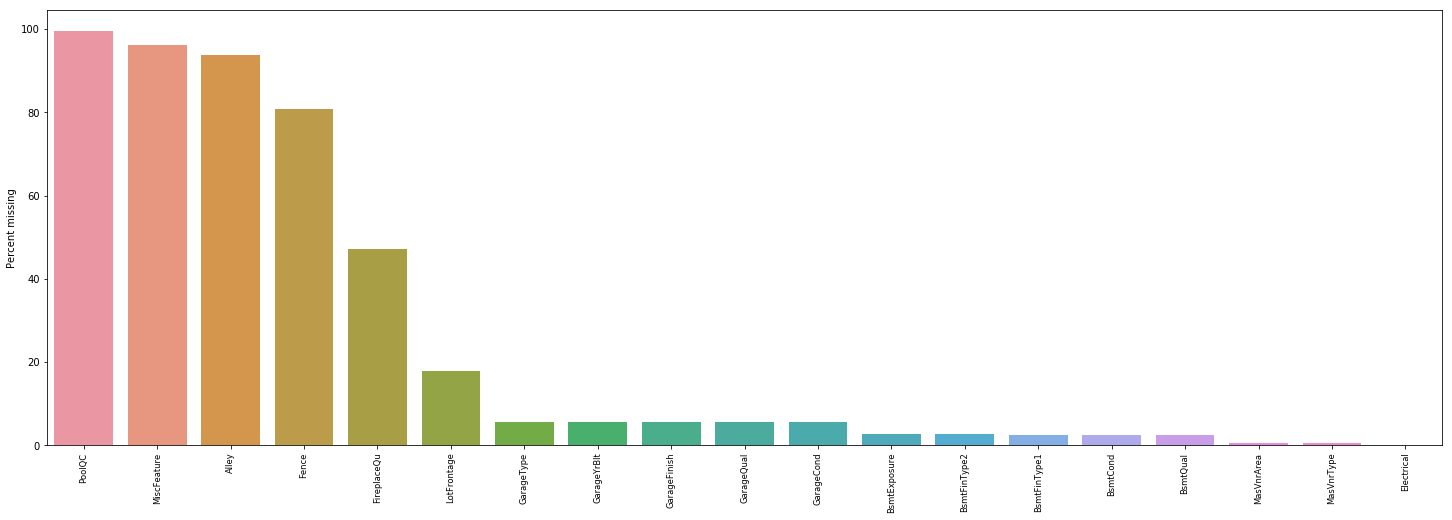

In [3]:
missing = pd.DataFrame({'Number of missing': pd.isnull(train).sum(axis = 0)[pd.isnull(train).sum(axis = 0) > 0],
              'Percent missing': round(pd.isnull(train).sum(axis = 0)[pd.isnull(train).sum(axis = 0) > 0]/train.shape[0]*100,2)})
missingDesc = missing.sort_values(by=['Percent missing'], ascending=False)
print(missingDesc)

plt.figure(figsize = (25, 8))  
p = sns.barplot(missingDesc.index, missingDesc['Percent missing'])
for label in p.get_xticklabels():
    p.set_xticklabels(missingDesc.index, rotation=90, fontsize='small')

In [4]:
PoolIndex = train[train['PoolArea']!=0].index  # Only these houses should receive a rating for pool qualiity, all others should be 'NA' rather than missing values.loc[np.logical_not(df_all_1.index.isin(PoolIndex)),'PoolQC'] = 'NA'
train.loc[np.logical_not(train.index.isin(PoolIndex)),'PoolQC'] = 'NA' #change from NaN to 'NA', meaning different
#train['PoolQC']

# # Impute the 3 true missing values
train['PoolQC'] = train['PoolQC'].fillna(train.PoolQC[PoolIndex].mode()[0])
train['PoolQC'].value_counts()


NA    1453
Gd       3
Ex       2
Fa       2
Name: PoolQC, dtype: int64

### Feature Engineering: Scores and Flags

In [5]:
# Garage flag: whether garage is attached (in some way) to buidling vs. standalone 

is_attached = train['GarageType'].isin(['Attchd', 'BuiltIn', 'Basment','2Types']) # enclosed in brackets accidentally, list.  Don't do!!

In [6]:
train['is_attached_garage'] = train.GarageType[is_attached]

In [7]:
train['is_attached_garage'] = train['is_attached_garage'].replace(to_replace="\w", regex=True, value=1)
train['is_attached_garage'] = train['is_attached_garage'].fillna(0)

In [8]:
train['is_attached_garage'] = train.GarageType[is_attached]

In [9]:
train = train.drop('GarageType', axis=1)

In [10]:
# Spring flag: houses sold in March, April, or June

is_spring = train['MoSold'].isin([3, 4, 5])

In [11]:
train['is_spring'] = train.MoSold[is_spring]

In [12]:
train['is_spring'] = train['is_spring'].fillna(0)

In [13]:
train['is_spring'] = train['is_spring'].apply(lambda x: 1 if x else 0) ## Great finally!

In [14]:
train = train.drop('MoSold', axis=1)

In [15]:
# Sold after 2008 flag

is_or_after_2008 = train['YrSold'].isin([2008, 2009, 2010])

In [16]:
train['is_or_after_2008'] = train.YrSold[is_or_after_2008]

In [17]:
train['is_or_after_2008'] = train['is_or_after_2008'].fillna(0)

In [18]:
train['is_or_after_2008'] = train['is_or_after_2008'].apply(lambda x: 1 if x else 0) ## Great finally!

In [19]:
# Better Condition1 flag: Near or adjacent to favorable conditions
is_good_condition1_a = train['Condition1'].isin(['PosN', 'RRNn','PosA']) # enclosed in brackets accidentally, list.  Don't do!!

In [20]:
train['is_good_condition1_a'] = train.Condition1[is_good_condition1_a]

In [21]:
train['is_good_condition1_a'] = train['is_good_condition1_a'].replace(to_replace="\w", regex=True, value=1)
train['is_good_condition1_a'] = train['is_good_condition1_a'].fillna(0)

In [22]:
train = train.drop('Condition1', axis=1)

In [23]:
# Better Condition2 flag: Near or adjacent to favorable conditions
is_good_condition2_a = train['Condition2'].isin(['PosN', 'RRNn','PosA']) # enclosed in brackets accidentally, list.  Don't do!!

In [24]:
train['is_good_condition2_a'] = train.Condition2[is_good_condition2_a]

In [25]:
train['is_good_condition2_a'] = train['is_good_condition2_a'].replace(to_replace="\w", regex=True, value=1)
train['is_good_condition2_a'] = train['is_good_condition2_a'].fillna(0)

In [26]:
train = train.drop('Condition2', axis=1)

In [27]:
# Total bathrooms above ground flag
train['totalbath_abv_ground'] = train['FullBath'] + train['HalfBath']

In [28]:
train = train.drop(['FullBath', 'HalfBath'], axis=1)

In [29]:
# Neighborhood flag: low, mid, high SalePrice neighborhoods
is_low = (train['SalePrice']) <= 150000
is_mid = (train['SalePrice'] <= 230000) & (train['SalePrice'] > 150000)
is_high = train['SalePrice'] > 230000

In [30]:
train['is_low_neighborhood'] = train.Neighborhood[is_low]
train['is_mid_neighborhood'] = train.Neighborhood[is_mid]
train['is_high_neighborhood'] = train.Neighborhood[is_high]

In [31]:
train['is_low_neighborhood'] = train['is_low_neighborhood'].replace(to_replace="\w", regex=True, value=1)
train['is_low_neighborhood'] = train['is_low_neighborhood'].fillna(0)
train['is_mid_neighborhood'] = train['is_mid_neighborhood'].replace(to_replace="\w", regex=True, value=1)
train['is_mid_neighborhood'] = train['is_mid_neighborhood'].fillna(0)
train['is_high_neighborhood'] = train['is_high_neighborhood'].replace(to_replace="\w", regex=True, value=1)
train['is_high_neighborhood'] = train['is_high_neighborhood'].fillna(0)

In [33]:
train[['Neighborhood', 'is_low_neighborhood', 'is_mid_neighborhood', 'is_high_neighborhood', 'SalePrice']].head()

,Neighborhood,is_low_neighborhood,is_mid_neighborhood,is_high_neighborhood,SalePrice
0,CollgCr,0.0,1.0,0.0,208500
1,Veenker,0.0,1.0,0.0,181500
2,CollgCr,0.0,1.0,0.0,223500
3,Crawfor,1.0,0.0,0.0,140000
4,NoRidge,0.0,0.0,1.0,250000


In [34]:
train = train.drop('Neighborhood', axis=1)

In [35]:
# 2ndFl flag (which is included in 'GrLivArea')
is_with_2ndFlr = train['2ndFlrSF'] != 0

In [36]:
train['is_with_2ndFlr'] = train['2ndFlrSF'][is_with_2ndFlr]

In [37]:
train['is_with_2ndFlr'] = train['is_with_2ndFlr'].fillna(0)

In [38]:
train['is_with_2ndFlr'] = train['is_with_2ndFlr'].apply(lambda x: 1 if x else 0) ## Great finally!

In [39]:
train[['2ndFlrSF', 'is_with_2ndFlr']].head()

,2ndFlrSF,is_with_2ndFlr
0,854,1
1,0,0
2,866,1
3,756,1
4,1053,1


In [40]:
train = train.drop('2ndFlrSF', axis=1)

In [41]:
# LocationScore: combining values from OverallQual, ExterQual, ExterCond, and Functional
# Map categorical to numeric values based on SalePrice
train['ExterQual'] = train['ExterQual'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2})
train['ExterCond'] = train['ExterCond'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2})
train['Functional'] = train['Functional'].map({'Typ': 5, 'Min1': 4, 'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sev': 1, 'Sal': 0})

In [42]:
train['LocationScore'] = ((train['OverallQual']/train['OverallQual'].mean()) + (train['OverallCond']/train['OverallCond'].mean()))
+ (train['ExterQual']/train['ExterQual'].mean()) + (train['ExterCond']/train['ExterCond'].mean())
+ (train['Functional']/train['Functional'].mean())
train['LocationScore'].head()

0    2.044476
1    2.418606
2    2.044476
3    2.044476
4    2.208429
Name: LocationScore, dtype: float64

In [43]:
train = train.drop(['ExterQual', 'ExterCond', 'Functional'], axis=1)

In [44]:
train.shape #(1460, 90) with feature engineering

(1460, 81)

In [45]:
# FireplaceScore: combining different fireplace attributes into one scroe
train['FireplaceQu_a'] = train['FireplaceQu'].map({'Ex': 2,
                                                 'Gd': 1.5,
                                                 'TA': 1.25,
                                                 'Fa': 1,
                                                 'Po': 0.75})

In [46]:
train['Fireplaces'] = train['Fireplaces'].fillna('0')

In [47]:
train['FireplaceScore'] = train['FireplaceQu_a'] * train['Fireplaces']
train['FireplaceScore'] = train['FireplaceScore'].fillna(0)
train[['FireplaceQu_a', 'Fireplaces','FireplaceScore']].head(5)

,FireplaceQu_a,Fireplaces,FireplaceScore
0,NaN,0,0.00
1,1.25,1,1.25
2,1.25,1,1.25
3,1.50,1,1.50
4,1.25,1,1.25


In [48]:
train = train.drop(['FireplaceQu_a', 'FireplaceQu', 'Fireplaces'], axis=1)

In [49]:
# GarageScore: combining different garage attributes into one score
train['GarageQual_a'] = train['GarageQual'].map({'Ex': 1.7, 'Gd': 1.4, 'TA': 1, 'Fa': 0.7, 'Po': 0.5})

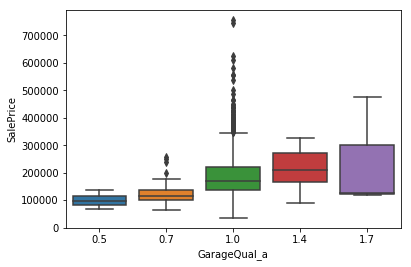

In [50]:
sns.boxplot(x='GarageQual_a', y='SalePrice', data=train)

In [51]:
train['GarageCond_a'] = train['GarageCond'].map({'Ex': 0.8, 'Gd': 1, 'TA': 1, 'Fa': 0.7, 'Po': 0.6})

In [52]:
train['GarageFinish_a'] = train['GarageFinish'].map({'Fin': 1.25, 'RFn': 1, 'Unf': 0.75})

In [53]:
train['GarageScore'] = train['GarageQual_a']*train['GarageCars']*train['GarageFinish_a']*train['GarageCond_a']

In [55]:
train[['GarageQual_a', 'GarageCars', 'GarageFinish_a', 'GarageCond_a', 'GarageScore']].head()

,GarageQual_a,GarageCars,GarageFinish_a,GarageCond_a,GarageScore
0,1.0,2,1.00,1.0,2.00
1,1.0,2,1.00,1.0,2.00
2,1.0,2,1.00,1.0,2.00
3,1.0,3,0.75,1.0,2.25
4,1.0,3,1.00,1.0,3.00


In [56]:
train = train.drop(['GarageQual', 'GarageQual_a', 'GarageCond', 'GarageCond_a','GarageFinish', 'GarageFinish_a'], axis=1)

In [57]:
# BasementScore: combining different basement attributes into one score

train['BsmtFinType1_a'] = train['BsmtFinType1'].map({'GLQ': 1.3, 'ALQ': 1.2, 'Unf': 1, 'Rec': 1, 'BLQ': 1, 'LwQ':1})

In [58]:
train['BsmtFinType2_a'] = train['BsmtFinType2'].map({'GLQ': 1.3, 'ALQ': 1.2, 'Unf': 1, 'Rec': 1, 'BLQ': 1, 'LwQ':1})

In [59]:
train['BsmtQual_a'] = train['BsmtQual'].map({'Ex': 1.8, 'Gd': 1.2, 'TA': 0.9, 'Fa': 0.9})

In [60]:
train['BsmtCond_a'] = train['BsmtCond'].map({'Gd': 1.2, 'TA': 1, 'Fa': 0.6, 'Po': 0.4})


In [61]:
# train['BsmtExposure'] = train['BsmtExposure'].fillna('Missing')
train['BsmtExposure_a'] = train['BsmtExposure'].map({'Gd': 1.3, 'No': 0.9, 'Mn': 1, 'Av': 1})

In [62]:
train['BsmtFinType2_a'] = train['BsmtFinType2'].map({'GLQ': 1.3, 'ALQ': 1.2, 'Unf': 1, 'Rec': 1, 'BLQ': 1, 'LwQ':1})

In [63]:
train['BsmtScore'] = train['BsmtExposure_a']*train['BsmtQual_a']*train['BsmtCond_a']*train['BsmtFinType1_a']*train['BsmtFinType2_a']

In [65]:
train[['BsmtCond_a', 'BsmtQual_a', 'BsmtExposure_a', 'BsmtFinType1_a', 'BsmtFinType2_a', 'BsmtScore']].head()

,BsmtCond_a,BsmtQual_a,BsmtExposure_a,BsmtFinType1_a,BsmtFinType2_a,BsmtScore
0,1.0,1.2,0.9,1.3,1.0,1.4040
1,1.0,1.2,1.3,1.2,1.0,1.8720
2,1.0,1.2,1.0,1.3,1.0,1.5600
3,1.2,0.9,0.9,1.2,1.0,1.1664
4,1.0,1.2,1.0,1.3,1.0,1.5600


In [66]:
train = train.drop(['BsmtFinType1', 'BsmtFinType1_a', 'BsmtFinType2', 'BsmtFinType2_a', 
                   'BsmtQual', 'BsmtQual_a', 'BsmtCond', 'BsmtCond_a', 'BsmtExposure', 'BsmtExposure_a'], axis=1)

In [67]:
print(train.shape) #(1460, 71 after flags and scores and dropping)
print(train.isna().sum().sum())

(1460, 74)
4908


In [68]:
train.to_csv('./data/train_tree_high.csv', index=False)

In [73]:
numeric_features_tree_high = train_tree_high.select_dtypes(include = ['int64','float64'])

In [75]:
numeric_features_tree_high = pd.DataFrame(numeric_features_tree_high, columns=numeric_features_tree_high.columns)
numeric_features_tree_high.to_csv("./data/numeric_features_tree_high.csv", index=False)

print(numeric_features_tree_high.shape) 
numeric_features_tree_high.isna().sum().sum()

(1460, 46)


468

In [77]:
categorical_features_tree_high = train_tree_high.select_dtypes(include = 'O')


(1460, 28)

In [78]:
categorical_features_tree_high = pd.DataFrame(categorical_features_tree_high, columns=categorical_features_tree_high.columns)
print(categorical_features_tree_high.shape)
categorical_features_tree_high.to_csv("./data/categorical_features_tree_high.csv", index=False)
categorical_features_tree_high.isna().sum().sum()

(1460, 28)


5893

### Relabel Categorical Features 

In [80]:
# Categorical relabel
import category_encoders as ce
categorical_features_relabel_high = categorical_features_tree_high.copy()

cols_relabel = categorical_features_tree_high.columns

encoder5 = ce.ordinal.OrdinalEncoder(cols=cols_relabel)

categorical_features_relabel_high = encoder5.fit_transform(categorical_features_relabel_high)
categorical_features_relabel_high.to_csv('./data/categorical_features_relabel_high.csv', index=False)

print(categorical_features_relabel_high.shape) # (1460, 37) from above after going through all new columns
categorical_features_relabel_high.isna().sum().sum()

(1460, 28)


0

In [81]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

numeric_features_scaled_high = sc.fit_transform(numeric_features_tree_high)
numeric_features_scaled_high = sc.transform(numeric_features_tree_high)
numeric_features_scaled_high = pd.DataFrame(numeric_features_scaled_high, columns=numeric_features_tree_high.columns)
numeric_features_scaled_high.to_csv('./data/numeric_features_scaled_high.csv', index=False)
print(numeric_features_scaled_high.shape) #(1460, 50) from above having gone through all those columns
numeric_features_scaled_high.isna().sum().sum()

(1460, 46)


468

In [82]:
train_scaled_relabel_high = pd.concat([numeric_features_scaled_high, categorical_features_relabel_high], axis=1)
print(train_scaled_relabel_high.shape) #(1460, 95)
train_scaled_relabel_high.isna().sum().sum()

(1460, 74)


468

             Number of missing  Percent missing
LotFrontage                259            17.74
GarageYrBlt                 81             5.55
GarageScore                 81             5.55
BsmtScore                   39             2.67
MasVnrArea                   8             0.55


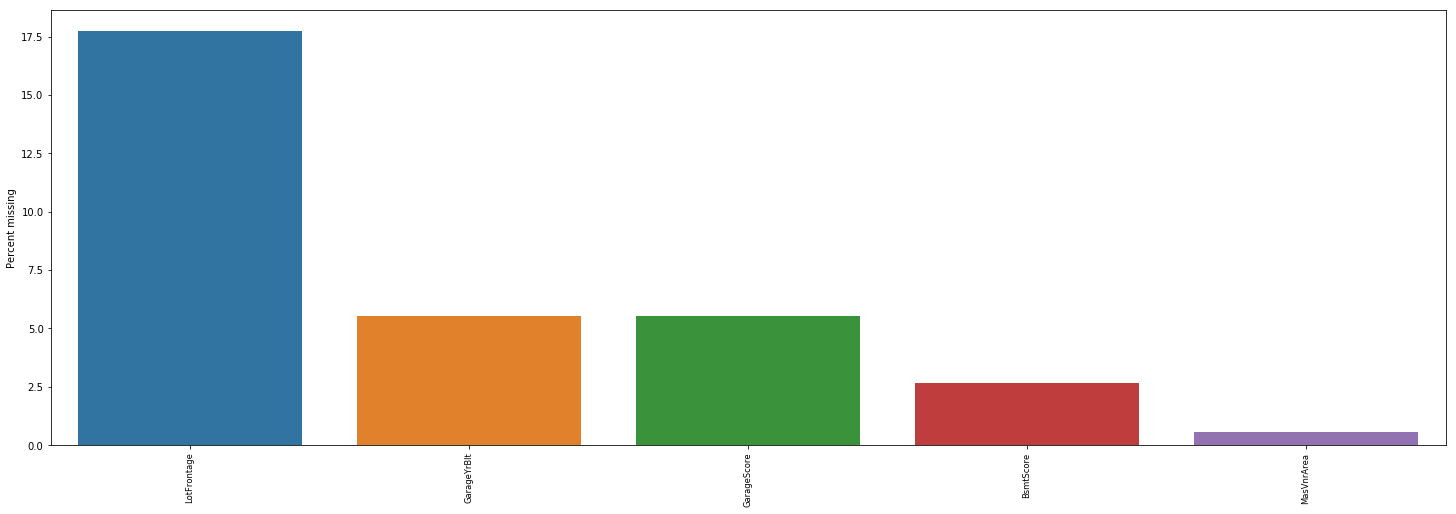

In [83]:
missing = pd.DataFrame({'Number of missing': pd.isnull(train_scaled_relabel_high).sum(axis = 0)[pd.isnull(train_scaled_relabel_high).sum(axis = 0) > 0],
              'Percent missing': round(pd.isnull(train_scaled_relabel_high).sum(axis = 0)[pd.isnull(train_scaled_relabel_high).sum(axis = 0) > 0]/train_scaled_relabel_high.shape[0]*100,2)})
missingDesc = missing.sort_values(by=['Percent missing'], ascending=False)
print(missingDesc)

plt.figure(figsize = (25, 8))  
p = sns.barplot(missingDesc.index, missingDesc['Percent missing'])
for label in p.get_xticklabels():
     p.set_xticklabels(missingDesc.index, rotation=90, fontsize='small')

In [84]:
PoolIndex = train_scaled_relabel_high[train_scaled_relabel_high['PoolArea']!=0].index  # Only these houses should receive a rating for pool qualiity, all others should be 'NA' rather than missing values.loc[np.logical_not(df_all_1.index.isin(PoolIndex)),'PoolQC'] = 'NA'
train.loc[np.logical_not(train_scaled_relabel_high.index.isin(PoolIndex)),'PoolQC'] = 'NA' #change from NaN to 'NA', meaning different
#train['PoolQC']
#train.loc[PoolIndex, 'PoolQC'].isnull().sum()

# # Impute the 3 true missing values
train_scaled_relabel_high['PoolQC'] = train_scaled_relabel_high['PoolQC'].fillna(train_scaled_relabel_high.PoolQC[PoolIndex].mode()[0])

1    1453
4       3
3       2
2       2
Name: PoolQC, dtype: int64

### Imputation: Most frequent

In [85]:
train_scaled_relabel_high = train_scaled_relabel_high.fillna(train_scaled_relabel_high.mode().iloc[0])
train_scaled_relabel_high = train_scaled_relabel_high.drop(['Id', 'MiscVal', 'MiscFeature', 'Fence', 'Alley'], axis=1)
train_scaled_relabel_high.to_csv("./data/train_scaled_relabel_high.csv", index=False)
print(train_scaled_relabel_high.shape) #(1460, 90) from the is_neighborhood etc new columns)
train_scaled_relabel_high.isna().sum().sum()

(1460, 69)


0

In [5]:
X = train_scaled_relabel_high.drop('SalePrice', axis=1)
print(X.shape) #(1460, 89)
X.isna().sum().sum()

(1460, 68)


0

In [6]:
y = train_scaled_relabel_high['SalePrice']
print(y.shape) #(1460, 89)
y.isna().sum().sum()

(1460,)


0

## Split into training and test sets

In [7]:
X_train_tree_high, X_test_tree_high, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train_tree_high.shape) #(1460, 89)
X_train_tree_high.isna().sum().sum()

(978, 68)


0

In [ ]:
X_train_tree_high.to_csv('./data/X_train_tree_high.csv', index=False)
X_test_tree_high.to_csv('./data/X_test_tree_high.csv', index=False)

### MODELS: Flags/Scores: is_high, is_mid_, is_low neighborhood
### GridSearchCV: Ridge, Lasso, ElasticNet, RandomForestRegressor, GradientBoostRegressor, SVR

### Ridge 

In [15]:
ridge = Ridge()
params1 = {'alpha': np.arange(0, 10),
          'max_iter': [10, 50, 100, 200, 300, 400, 500, 600, 700],
          'solver': ['cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

grid1 = GridSearchCV(ridge, params1, n_jobs=-1)

grid1.fit(X_train_tree_high, y_train)
pred=grid1.predict(X_test_tree_high)

train_score = grid1.score(X_train_tree_high, y_train)
test_score = grid1.score(X_test_tree_high, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid1_best_params = grid1.best_params_
print(grid1_best_params)
print('GridsearchCV best_score is {:.4%}'.format(grid1.best_score_))

The train score is 0.8959
The test score is 0.8219
The R-squared is 0.8219
The root mean squared is 0.4553
The mean squared error is 0.2073
The mean absolute error is is 0.256
{'alpha': 6.2, 'max_iter': 10, 'solver': 'saga'}
GridsearchCV best_score is 82.1677%


### Lasso

In [16]:
lasso = Lasso(random_state=42)
params2 = {'alpha': np.arange(0, 10),
          'max_iter': np.arange(1, 700, 5),
          'selection':['cyclic', 'random']}

grid2 = GridSearchCV(lasso, params2, n_jobs=-1)

grid2.fit(X_train_tree_high, y_train)
pred=grid2.predict(X_test_tree_high)

train_score = grid2.score(X_train_tree_high, y_train)
test_score = grid2.score(X_test_tree_high, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid2_best_params = grid2.best_params_
print(grid2_best_params)
print('GridSearchCV best_score is {:.4%}'.format(grid2.best_score_))

The train score is 0.9022
The test score is 0.8489
The R-squared is 0.8489
The root mean squared is 0.4194
The mean squared error is 0.1759
The mean absolute error is is 0.2511
{'alpha': 0, 'max_iter': 26, 'selection': 'cyclic'}
GridSearchCV best_score is 65.7243%


### ElasticNet

In [11]:
elastic = ElasticNet(random_state=42)
params4 = {"alpha": np.arange(0, 10),
          "max_iter": np.arange(1, 700, 5),
          'l1_ratio': [0.1, 0.4, 0.7, 0.9]}

grid4 = GridSearchCV(elastic, params4, n_jobs=-1)

grid4.fit(X_train_tree_high, y_train)
pred=grid4.predict(X_test_tree_high)

train_score = grid4.score(X_train_tree_high, y_train)
test_score = grid4.score(X_test_tree_high, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid4_best_params = grid4.best_params_
print(grid4_best_params)
print('GridSearchCV best_score is {:.4%}'.format(grid4.best_score_))

The train score is 0.8676
The test score is 0.8231
The R-squared is 0.8231
The root mean squared is 0.4538
The mean squared error is 0.2059
The mean absolute error is is 0.2455
{'alpha': 0.06, 'l1_ratio': 0.7, 'max_iter': 11}
GridSearchCV best_score is 83.1750%


### Random Forest Regressor

In [61]:
randomforest = RandomForestRegressor(verbose=0)
params5 = {"criterion": ['mae','mse'],
          "min_samples_leaf": range(1, 10),
          "min_samples_split": np.linspace(start=2, stop=30,
                    num=15, dtype=int),
          "max_depth": range(1,10),
          "n_estimators": np.linspace(1, 1000, num=15, dtype=int),
          "max_features": range(5, 60, 5)}
#           'oob_score'= True}
 
grid5 = RandomizedSearchCV(randomforest, params5)

grid5.fit(X_train_tree_high, y_train)
pred=grid5.predict(X_test_tree_high)

train_score = grid5.score(X_train_tree_high, y_train)
test_score = grid5.score(X_test_tree_high, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is is {:.4}'.format(mae))

grid5_best_params = grid5.best_params_
print(grid5_best_params)
print('RandomizedSearchCV best_score is {:.4%}'.format(grid5.best_score_))

The train score is 0.9816
The test score is 0.9011
The R-squared is 0.9011
The root mean squared is 0.3394
The mean squared error is 0.1152
The mean absolute error is is 0.1948
{'n_estimators': 785, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 40, 'max_depth': 9, 'criterion': 'mae'}
RandomizedSearch best_score is 90.7067%


In [98]:
randomforest = RandomForestRegressor(n_estimators=215, min_samples_split=12, min_samples_leaf=4, max_features=40, max_depth=7, criterion='mse')
randomforest.fit(X_train_tree_high, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=40, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=215, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

### Feature Importances: RandomForest (Flags & Scores)

In [101]:
sorted_importance_random_high= sorted(zip(X_train_tree_high.columns, randomforest.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_random_high= sorted_importance_random_high[:15] #lambda use to indicate second item
sorted_importance_random_high

[('is_high_neighborhood', 0.43502559689846415),
 ('is_low_neighborhood', 0.18963722335430275),
 ('OverallQual', 0.10720600288275464),
 ('is_mid_neighborhood', 0.07598372376039794),
 ('GrLivArea', 0.03690093168494146),
 ('BsmtScore', 0.03560916350730025),
 ('TotalBsmtSF', 0.020117177824052607),
 ('GarageScore', 0.013403981829528133),
 ('1stFlrSF', 0.010708502828941223),
 ('YearBuilt', 0.009500604557749226),
 ('LocationScore', 0.007109888993105986),
 ('MasVnrArea', 0.00644845507925995),
 ('BsmtFinSF1', 0.006379503375371074),
 ('GarageArea', 0.006095953308317396),
 ('TotRmsAbvGrd', 0.005112715609090095)]

### Gradient Boosting Regressor

In [102]:
gbm6 = GradientBoostingRegressor()
gbm6.fit(X_train_tree_high, y_train)

params6 = {"criterion": ['mae','mse'],
                       "min_samples_leaf": range(1, 10),
                       "min_samples_split": np.linspace(start=2, stop=30,
                                        num=15, dtype=int),
                       "max_depth": range(1,10),
                       "alpha": [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],
                       "n_estimators": np.linspace(1, 1000, num=15, dtype=int),
                        "subsample": [0.8, 0.9, 1.0],
                       "max_features": range(5, 80, 5)}

grid6 = RandomizedSearchCV(gbm6, params6)

grid6.fit(X_train_tree_high,y_train)
pred=grid6.predict(X_test_tree)

train_score = grid6.score(X_train_tree_high, y_train)
test_score = grid6.score(X_test_tree_high, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is {:.4}'.format(mae))

grid6_best_params = grid6.best_params_
print(grid6_best_params)
print('RandomizedSearchCV best_score is {:.4%}'.format(grid6.best_score_))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [103]:
gbm6.score(X_train_tree_high, y_train)

0.9771460746255713

In [104]:
gbm6.score(X_test_tree_high, y_test)

0.9158755639825559

### Feature Importances: GradientBoosting (Flags & Scores)

In [105]:
sorted_importance_gbm_high= sorted(zip(X_train_tree_high.columns, gbm6.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_gbm_high= sorted_importance_gbm_high[:15] #lambda use to indicate second item
sorted_importance_gbm_high

[('is_high_neighborhood', 0.5964720093419735),
 ('is_low_neighborhood', 0.07408564782032451),
 ('is_mid_neighborhood', 0.06486665031184136),
 ('GrLivArea', 0.063631552597128),
 ('OverallQual', 0.05441731441198861),
 ('BsmtScore', 0.04528969249778369),
 ('TotalBsmtSF', 0.02299954981373865),
 ('BsmtFinSF1', 0.008536339316733208),
 ('LocationScore', 0.008330050743906496),
 ('YearBuilt', 0.007851528646802525),
 ('1stFlrSF', 0.006616091781021039),
 ('GarageScore', 0.00567913612982756),
 ('TotRmsAbvGrd', 0.0052169979202107315),
 ('LotArea', 0.004913991940014669),
 ('GarageArea', 0.0045448625168160684)]

Text(0.5, 1.0, 'GBM Feature Importance (Flags included: Neighborhood (high, mid, low), LocationScore, GarageScore, TotBaths, 2ndFlr)')

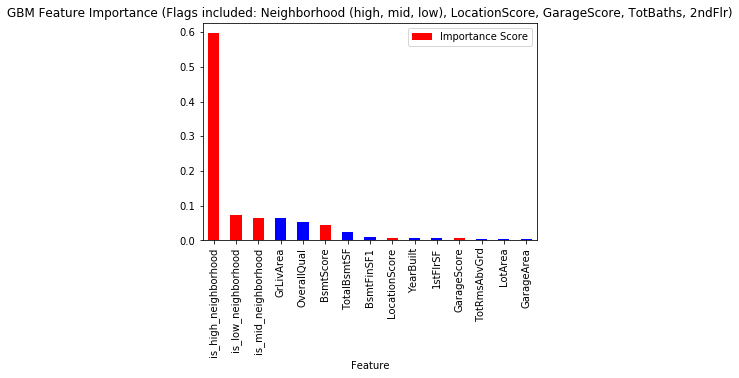

In [110]:
x, y = zip(*sorted_importance_gbm_high)
barplot_encoded_tree_high = pd.DataFrame({'Feature': x, 'Importance Score':y}).plot.bar(x='Feature', y='Importance Score',
                    color=['red', 'red', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'blue'])
plt.title('GBM Feature Importance (Flags included: Neighborhood (high, mid, low), LocationScore, GarageScore, TotBaths, 2ndFlr)')

### SVM

In [12]:
from sklearn.svm import SVR
svr = SVR(epsilon = 1e-4, gamma=1)
svr.fit(X_train_tree_high, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [14]:
print(svr.score(X_train_tree_high, y_train))
print(svr.score(X_test_tree_high, y_test))

0.7440235180606001
-0.01040082255821373


In [102]:
svrsearch = SVR()
params7a = {'C': [0.001, 1, 10, 100, 1000],
           'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 0, 10, 100, 1000, 10000, 100000],
           'kernel': ['poly'],
          'degree': [1, 2, 3, 4, 5]
           }
params7b = {'C': [0.001, 1, 10, 100, 1000],
          'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 0, 10, 100, 1000, 10000, 100000],
          'gamma': [100000, 10000, 1000, 100, 10, 1, 0.001, 0.0001],
           'kernel': ['rbf']}

The train score is 0.9925
The test score is 0.7547
The R-squared is 0.7547
The root mean squared is 0.5344
The mean squared error is 0.2856
The mean absolute error is 0.2851
{'kernel': 'poly', 'epsilon': 0.0001, 'degree': 2, 'C': 10}
RandomizedSearch best_score is 36.9829%


In [ ]:
# First set of GridSearchCV parameters

gridsearch_svm7a = model_selection.GridSearchCV(svrsearch, params7a, cv=3, iid=True, n_jobs=-1)
gridsearch_svm7a.fit(X_train_tree_high, y_train)

train_score = gridsearch_svm7a.score(X_train_tree_high, y_train)
test_score = gridsearch_svm7a.score(X_test_tree_high, y_test) # same thing as R2, just testing
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
mse = mean_squared_error(y_test,pred)
mae = mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is {:.4}'.format(mae))

gridsearch_best_params7a = gridsearch_svm7a.best_params_
print(gridsearch_best_params7a)
print('GridSearchCV best_score is {:.4%}'.format(gridsearch_svm7a.best_score_))

In [ ]:
# Second set of GridSearchCV parameters

gridsearch_svm7b = model_selection.GridSearchCV(svrsearch, params7b, cv=3, iid=True, n_jobs=-1)
gridsearch_svm7b.fit(X_train_tree_high, y_train)

train_score = gridsearch_svm7b.score(X_train_tree_high, y_train)
test_score = gridsearch_svm7b.score(X_test_tree_high, y_test)
Rs = r2_score(y_test, pred) # r2_score(ytrue, ypred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
mse = mean_squared_error(y_test,pred)
mae = mean_absolute_error(y_test, pred)

print('The train score is {:.4}'.format(train_score))
print('The test score is {:.4}'.format(test_score)) # same thing as R2, just testing
print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))
print('The mean squared error is {:.4}'.format(mse))
print('The mean absolute error is {:.4}'.format(mae))

gridsearch_best_params7b = gridsearch_svm7b.best_params_
print(gridsearch_best_params7b)
print('GridSearchCV best_score is {:.4%}'.format(gridsearch_svm7b.best_score_))